In [143]:
!pip install --upgrade transformers
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import gc
from tqdm.autonotebook import tqdm

from sklearn.metrics import accuracy_score,f1_score

import sklearn

import torch
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [145]:
train = pd.read_csv("/content/I-Sarcasm_train_.csv")
test = pd.read_csv("/content/I-Sarcasm_test_.csv")

In [146]:
train.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,NaN
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,NaN
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,NaN
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,NaN
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [147]:
train.tweet[0]

"It's been a while since I visited my grandparents.#wait"

In [148]:
test.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,NaN
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,NaN
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,NaN
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [149]:
train.isna().sum()

tweet_id            0
tweet               0
sarcasm_label       0
sarcasm_type     2298
dtype: int64

In [150]:
train["sarcasm_type"].fillna("No sarcasm",inplace=True)
train.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,No sarcasm
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,No sarcasm
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,No sarcasm
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,No sarcasm
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [151]:
test.isna().sum()

tweet_id           0
tweet              0
sarcasm_label      0
sarcasm_type     640
dtype: int64

In [152]:
test["sarcasm_type"].fillna("No sarcasm",inplace=True)
test.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,No sarcasm
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,No sarcasm
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,No sarcasm
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [153]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train.drop("tweet_id",inplace=True,axis=1)

In [154]:
test.drop("tweet_id",inplace=True,axis=1)

In [155]:
train_tweets=train['tweet'].tolist()
test_tweets=test['tweet'].tolist()


In [156]:
train.sarcasm_type.replace("#news #live #breakingnews Premarket: Blood-letting eases for global stocks, but China smashed again","No sarcasm",inplace=True)

In [157]:
train.describe().T

,count,unique,top,freq
tweet,3577,3523,LOL...Walker is talking about education...the ...,3
sarcasm_label,3577,2,not_sarcastic,2297
sarcasm_type,3577,7,No sarcasm,2299


In [158]:
train = train.sample(frac = 1)
test = test.sample(frac = 1)

**Value counts of individual sarcasm labels**

In [159]:
train.sarcasm_label.value_counts()

not_sarcastic    2297
sarcastic        1280
Name: sarcasm_label, dtype: int64

**Countplot sarcasm_label(s)**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


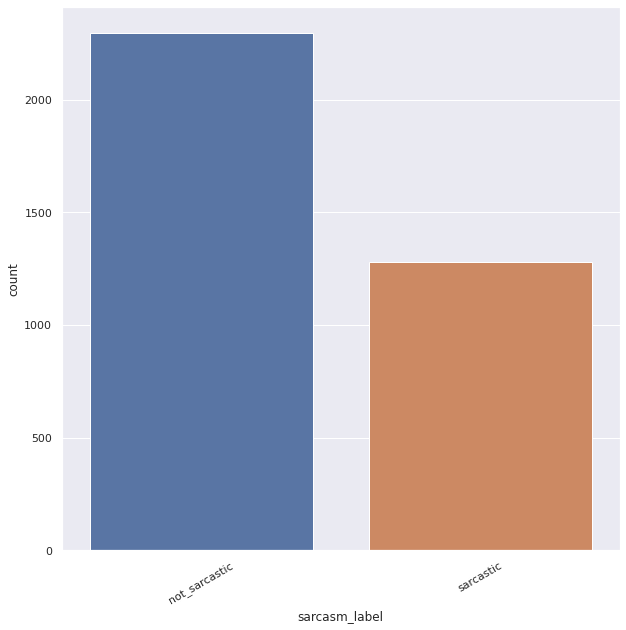

In [160]:
sns.countplot(train.sarcasm_label)
sns.set(rc={'figure.figsize':(7,8)})
plt.xticks(rotation=30);

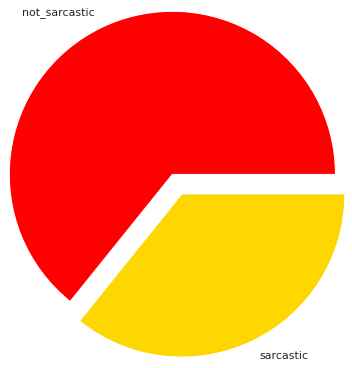

In [161]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1]
train.sarcasm_label.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["red", "gold", "green",'blue','purple','red']);


**Value counts of individual sarcasm types**

In [162]:
train.sarcasm_type.value_counts()

No sarcasm             2299
sarcasm                 880
irony                   261
overstatement            47
rhetorical question      43
satire                   39
understatement            8
Name: sarcasm_type, dtype: int64

**Countplot of various sarcasm_type(s**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


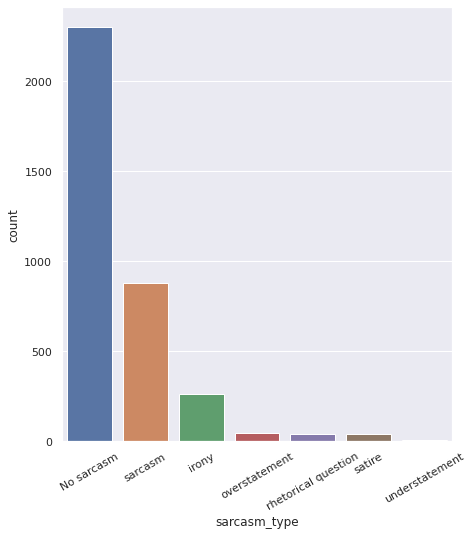

In [163]:
sns.countplot(train.sarcasm_type)
sns.color_palette("mako", as_cmap=True)

plt.xticks(rotation=30);

**Piechart depecting sarcasm_type**

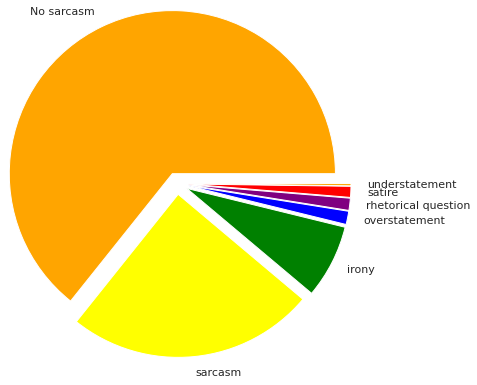

In [164]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1]
sns.set_theme(style="whitegrid")
train.sarcasm_type.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["orange", "yellow", "green",'blue','purple','red']);


In [165]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    # emoji_pattern = re.compile(
    #     '['
    #     u'\U0001F600-\U0001F64F'  # emoticons
    #     u'\U0001F300-\U0001F5FF'  # symbols & pictographs
    #     u'\U0001F680-\U0001F6FF'  # transport & map symbols
    #     u'\U0001F1E0-\U0001F1FF'  # flags
    #     u'\U00002702-\U000027B0'
    #     u'\U000024C2-\U0001F251'
    #     ']+',
    #     flags=re.UNICODE)
    # tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    # #Punctuations and special characters
    
    # tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    tweet = tweet.replace("#"," ")
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)

    
    
    return tweet

In [166]:
tqdm.pandas() 

train['tweet']= train['tweet'].progress_apply((lambda x: clean(x))) 
test['tweet'] = test['tweet'].progress_apply((lambda x: clean(x)))

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

In [167]:
train["tweet"] = train["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
train.head(10)

,tweet,sarcasm_label,sarcasm_type
1465,want solid self confidence confident ebooklove...,not_sarcastic,No sarcasm
2043,harvard research says cara delevingne sarcasm ...,sarcastic,sarcasm
186,person without sense humor like wagon without ...,not_sarcastic,No sarcasm
2981,good morning goodmorning coffeemorning coffeel...,not_sarcastic,No sarcasm
3444,old crap forgotten tricks 80s later caused 2 w...,not_sarcastic,No sarcasm
446,give one good reason supporting justin gatlin ...,not_sarcastic,No sarcasm
1209,lastest pharmaceutical drugs auctions pharmace...,not_sarcastic,No sarcasm
2642,bello big leap towards peace colombia farc pea...,not_sarcastic,No sarcasm
3148,become reading warrior andrea n carr articles ...,not_sarcastic,No sarcasm
848,prem rawat peace talk wopg peace english insp...,not_sarcastic,No sarcasm


In [168]:
test["tweet"] = test["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
test.head(10)

,tweet,sarcasm_label,sarcasm_type
107,hell sport postal service singing one song new...,not_sarcastic,No sarcasm
850,trz everyday peace power love respect,not_sarcastic,No sarcasm
319,americans selfcentered cannot even figure self...,sarcastic,irony
179,education great contentmarketing strategy 17 e...,not_sarcastic,No sarcasm
183,analysis chinaus hacking accord tall rhetoric ...,not_sarcastic,No sarcasm
549,news travel jacket funded clothing item histor...,not_sarcastic,No sarcasm
139,yay drunk broads next us already poured wine f...,sarcastic,sarcasm
131,news gets even better sarcastic darkmatter fiv...,sarcastic,sarcasm
96,comment code sooo great codingconflicts sarcasm,sarcastic,sarcasm
450,also elha good sa emotions essence emotions ma...,not_sarcastic,No sarcasm


In [169]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

train["tweet"] = train["tweet"].apply(lambda text: remove_punctuation(text))
train.head()

,tweet,sarcasm_label,sarcasm_type
1465,want solid self confidence confident ebooklove...,not_sarcastic,No sarcasm
2043,harvard research says cara delevingne sarcasm ...,sarcastic,sarcasm
186,person without sense humor like wagon without ...,not_sarcastic,No sarcasm
2981,good morning goodmorning coffeemorning coffeel...,not_sarcastic,No sarcasm
3444,old crap forgotten tricks 80s later caused 2 w...,not_sarcastic,No sarcasm


In [170]:

# PUNCT_TO_REMOVE = string.punctuation
# def remove_punctuation(text):
#     """custom function to remove the punctuation"""
#     return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

test["tweet"] = test["tweet"].apply(lambda text: remove_punctuation(text))
test.head()

,tweet,sarcasm_label,sarcasm_type
107,hell sport postal service singing one song new...,not_sarcastic,No sarcasm
850,trz everyday peace power love respect,not_sarcastic,No sarcasm
319,americans selfcentered cannot even figure self...,sarcastic,irony
179,education great contentmarketing strategy 17 e...,not_sarcastic,No sarcasm
183,analysis chinaus hacking accord tall rhetoric ...,not_sarcastic,No sarcasm


In [171]:
train.drop("sarcasm_type",inplace=True,axis=1)
test.drop("sarcasm_type",inplace=True,axis=1)


In [172]:
train = train.sort_index(ascending=True)

train.tail(10) 


,tweet,sarcasm_label
3567,obama cameron hollande merkel presiding regime...,sarcastic
3568,cnn hosts gopdebate sept16th join us postdebat...,not_sarcastic
3569,video building tower 3000 shops bbc news uk ne...,not_sarcastic
3570,news actuality tweet shows escaped el chapo dr...,not_sarcastic
3571,rx drugs oval white pill n 60 yes 60mg morphi...,not_sarcastic
3572,hey christine nixon people like cover every si...,not_sarcastic
3573,erythropoietin drugs market reach 119 billion ...,not_sarcastic
3574,apples first android app wants stop using andr...,sarcastic
3575,hurry ending soon follow b4 160915 4chance2win...,not_sarcastic
3576,alcohol drug treatment court accept people rac...,not_sarcastic


In [173]:
test = test.sort_index(ascending=True)

test.tail(10) 

,tweet,sarcasm_label
897,n korean womans family says kidnapped abroad a...,not_sarcastic
898,tyonews us announces 19m grants expand use bod...,not_sarcastic
899,whitehouse fire company welcomes new engine 22...,not_sarcastic
900,new edition read todays good news online fam...,not_sarcastic
901,learn safety privacy article safety education ...,not_sarcastic
902,subject likely prominent next gopdebate wise s...,not_sarcastic
903,get rid best education suggestion,not_sarcastic
904,top blogger templates blogger education inspir...,not_sarcastic
905,politics football iowa politics,not_sarcastic
906,plan remove damaged bridge causes stir white m...,not_sarcastic


In [174]:
test.head(10)

,tweet,sarcasm_label
0,gandhis busy congress delays brainstorming ses...,sarcastic
1,george ice cream castle charlie wolf educatio...,not_sarcastic
2,hartford house delegation scores funding city ...,not_sarcastic
3,obama rename tallest us peak hear white house ...,not_sarcastic
4,couldnt care less guess oh cant forget right ...,sarcastic
5,no deflategate judge going announce decision t...,not_sarcastic
6,cubalibregrace mining china world drugs cr...,not_sarcastic
7,china russia waging war america politics dnc gop,not_sarcastic
8,latest james okeefe sting video targeting clin...,not_sarcastic
9,immigration please brownpride jebbush economy ...,not_sarcastic


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


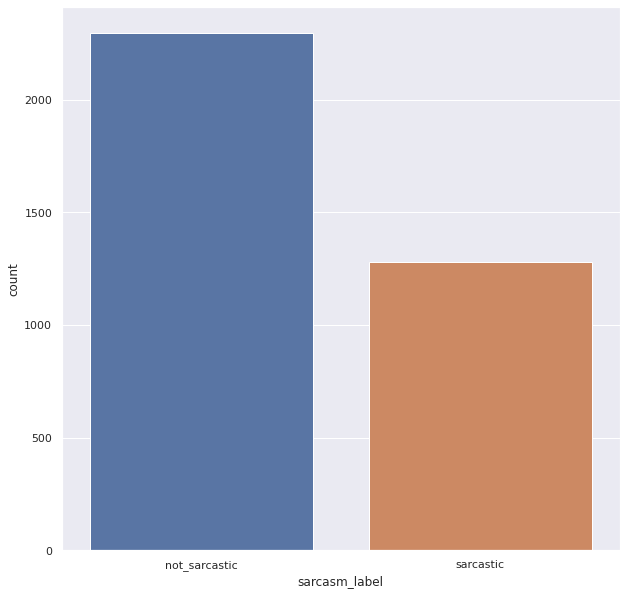

In [175]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train['sarcasm_label'])

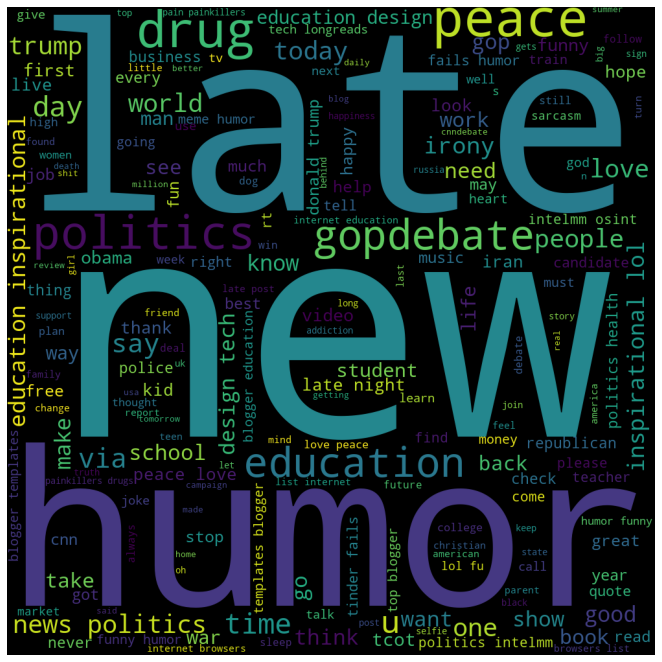

In [176]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet[train['sarcasm_label']=='not_sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='black',stopwords=stopwords,
                         min_font_size=4).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

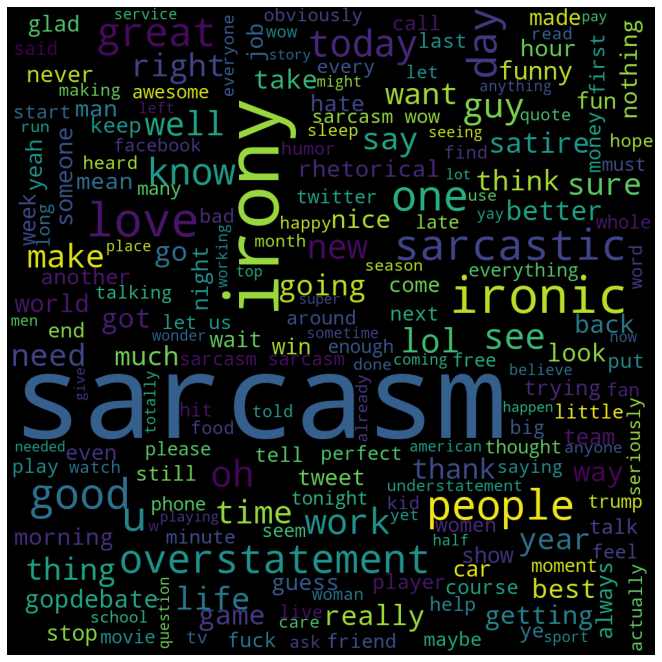

In [177]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet[train['sarcasm_label']=='sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='black',stopwords=stopwords,
                         min_font_size=10).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

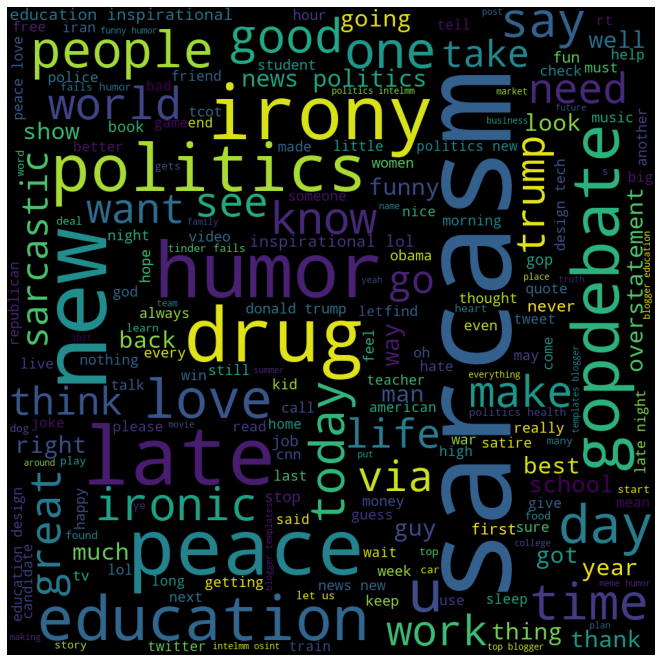

In [178]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='black',stopwords=stopwords,
                         min_font_size=10).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [179]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'not_sarcastic':0,
        'sarcastic':1
    }
    return class_dict[t_class]

In [180]:
train["target"] = train['sarcasm_label'].apply(lambda x: encode_target(x))
test["target"] = test['sarcasm_label'].apply(lambda x: encode_target(x))

In [181]:
train = train[['tweet','target']]
train.columns = ['text','labels']

test = test[['tweet','target']]
test.columns = ['text','labels']

In [182]:
train.head()

,text,labels
0,since visited grandparents wait,0
1,well done monty mark first ever 100 honest acc...,0
2,since fantasy individual time alive today,0
3,really think know talking about please provide...,0
4,missed toughenough tonight worries watch episo...,1


In [183]:
test.head()

,text,labels
0,gandhis busy congress delays brainstorming ses...,1
1,george ice cream castle charlie wolf educatio...,0
2,hartford house delegation scores funding city ...,0
3,obama rename tallest us peak hear white house ...,0
4,couldnt care less guess oh cant forget right ...,1


In [184]:
model = ClassificationModel(
    "bert", "dbmdz/bert-base-turkish-cased",
    num_labels=4,
    args=train_args
)

NameError: ignored

In [195]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 128,
               'gradient_accumulation_steps': 2,
#                'do_lower_case': True,
               'learning_rate': 1e-5,
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 1}


In [196]:
model = ClassificationModel(model_type, model_name,num_labels=4,args=model_args,use_cuda=False) 
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=train_args
# ) 
#args=model_args


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [197]:
model.train_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/28 [00:00<?, ?it/s]

(14, 1.2729303879397256)

In [198]:
result, model_outputs, wrong_predictions = model.eval_model(test,acc=accuracy_score)

  0%|          | 0/907 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [199]:
print("TEST SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result['acc']*100))
print("%s: %.5f" % ('Final Loss', result['eval_loss']))

TEST SET EVALUATION:
Accuracy: 70.56%
Final Loss: 1.20708
